In [1]:
import pandas as pd
import numpy as np
from __future__ import division

#disable warnings in notebook
import warnings
warnings.filterwarnings('ignore')


In [2]:
leave_df = pd.read_csv('../data/raw_data.csv')
col_names = leave_df.columns.tolist()

print "Column names:"
print col_names

print "\nSample data:"
leave_df.head(6)

Column names:
['name', 'satisfaction_level', 'last_evaluation', 'number_projects', 'average_monthly_hours', 'time_spent_company', 'work_accident', 'left', 'promotion_last_5_years', 'department', 'salary', 'salary_level']

Sample data:


,name,satisfaction_level,last_evaluation,number_projects,average_monthly_hours,time_spent_company,work_accident,left,promotion_last_5_years,department,salary,salary_level
0,SMITH,0.38,0.53,2,157,3,0,1,0,sales,low,1
1,JOHNSON,0.80,0.86,5,262,6,0,1,0,sales,medium,2
2,WILLIAMS,0.11,0.88,7,272,4,0,1,0,sales,medium,2
3,BROWN,0.72,0.87,5,223,5,0,1,0,sales,low,1
4,JONES,0.37,0.52,2,159,3,0,1,0,sales,low,1
5,MILLER,0.41,0.50,2,153,3,0,1,0,sales,low,1


In [3]:
# Isolate target data
y = leave_df['left']

# We don't need these columns
to_drop = ['name', 'salary', 'left']
leave_feat_space = leave_df.drop(to_drop,axis=1)

# Pull out features for future use
features = leave_feat_space.columns

# convert label features to integers
from sklearn import preprocessing
le_sales = preprocessing.LabelEncoder()
le_sales.fit(leave_feat_space["department"])
leave_feat_space["department"] = le_sales.transform(leave_feat_space.loc[:,('department')])

# transforme the whole feature space into a matrix
X = leave_feat_space.as_matrix().astype(np.float)

# standardize all features
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

print "Feature space holds %d observations and %d features" % X.shape
print "Unique target labels:", np.unique(y)

Feature space holds 14999 observations and 9 features
Unique target labels: [0 1]


In [4]:
# prediction function
def run_cv(X,y,clf_class, method, **kwargs):
    
    from sklearn.model_selection import cross_val_predict
    
    # Initialize a classifier with key word arguments
    clf = clf_class(**kwargs)
    
    predicted = cross_val_predict(clf, X, y, cv=3, method=method)
    
    return predicted

In [5]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn import metrics

def accuracy(y, predicted):
    # NumPy interprets True and False as 1. and 0.
    return metrics.accuracy_score(y, predicted)

print "Support vector machines:"
print "%.3f" % accuracy(y, run_cv(X,y,SVC, method='predict'))
print "Random forest:"
print "%.3f" % accuracy(y, run_cv(X,y,RF, method='predict'))
print "K-nearest-neighbors:"
print "%.3f" % accuracy(y, run_cv(X,y,KNN, method='predict'))

Support vector machines:
0.958
Random forest:
0.989
K-nearest-neighbors:
0.952


In [6]:
from sklearn.metrics import confusion_matrix

y = np.array(y)
class_names = np.unique(y)

# calculate confusion matrices
confusion_matrices = [
    ( "Support Vector Machines", confusion_matrix(y,run_cv(X,y,SVC, method='predict')) ),
    ( "Random Forest", confusion_matrix(y,run_cv(X,y,RF, method='predict')) ),
    ( "K-Nearest-Neighbors", confusion_matrix(y,run_cv(X,y,KNN, method='predict')) ),
]

# show confusion matrix values
print confusion_matrices


[('Support Vector Machines', array([[11135,   293],
       [  332,  3239]])), ('Random Forest', array([[11373,    55],
       [  116,  3455]])), ('K-Nearest-Neighbors', array([[11002,   426],
       [  289,  3282]]))]


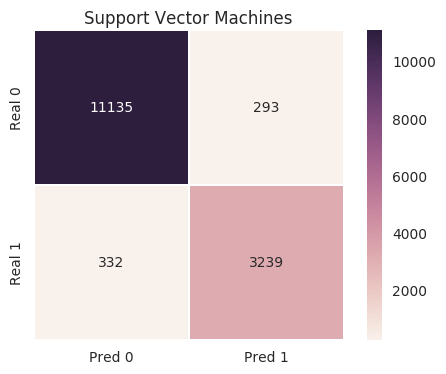

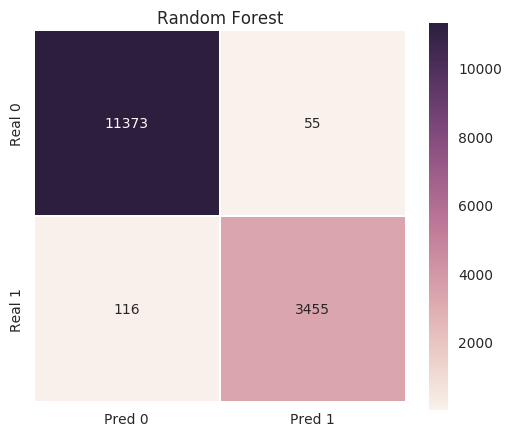

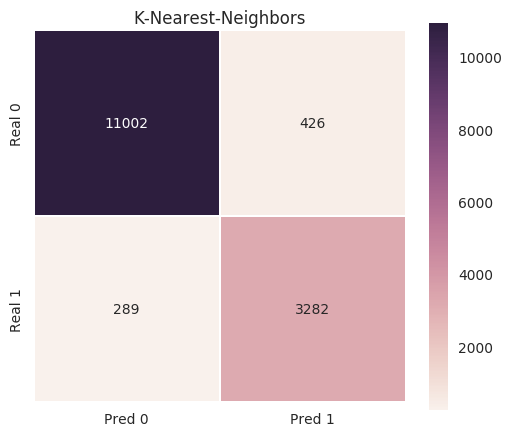

In [7]:
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

# draw confusion matrices
for cf in confusion_matrices:

    ax = plt.axes()
    ax.set_title(cf[0])
    
    df_cm = pd.DataFrame(cf[1], index = ["Real 0", "Real 1"], columns = ["Pred 0", "Pred 1"])
    plt.figure(figsize = (6,5))
    sn.heatmap(df_cm, annot=True, ax = ax, square=True, fmt="d",linewidths=.5)

In [8]:
# Use 10 estimators so predictions are all multiples of 0.1
pred_prob = run_cv(X, y, RF, n_estimators=10,  method='predict_proba',)

pred_leave = pred_prob[:,1]
is_leave = y == 1

# Number of times a predicted probability is assigned to an observation
counts = pd.value_counts(pred_leave)

# calculate true probabilities
true_prob = {}
for prob in counts.index:
    true_prob[prob] = np.mean(is_leave[pred_leave == prob])
    true_prob = pd.Series(true_prob)

# pandas-fu
counts = pd.concat([counts,true_prob], axis=1).reset_index()
counts.columns = ['pred_prob', 'count', 'true_prob']
counts

,pred_prob,count,true_prob
0,0.0,9371,0.005122
1,1.0,3118,0.993906
2,0.1,1454,0.013755
3,0.2,387,0.023256
4,0.9,188,0.968085
5,0.3,168,0.059524
6,0.8,84,0.904762
7,0.7,73,0.945205
8,0.4,72,0.111111
9,0.5,47,0.404255


In [9]:
#create a dataframe containing prob values
pred_prob_df = pd.DataFrame(pred_prob)
pred_prob_df.columns = ['prob_not_leaving', 'prob_leaving']

#merge dataframes to get the name of employees
all_employees_pred_prob_df = pd.concat([leave_df, pred_prob_df], axis=1)

#filter out employees still in the company and having a good evaluation
good_employees_still_working_df = all_employees_pred_prob_df[(all_employees_pred_prob_df["left"] == 0) & 
                                                            (all_employees_pred_prob_df["last_evaluation"] >= 0.7)]

good_employees_still_working_df.sort_values(by='prob_leaving', ascending=False, inplace=True)

#write to csv
good_employees_still_working_df.to_csv("/home/demos/hr-analytics/output/good_employees_leaving_prob.csv")
